In [28]:
import pandas as pd
import numpy as np 

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold

## Loading

In [2]:
df = pd.read_csv('../data/raw/no_stock.csv')

/var/folders/fm/g7cx2fj16_7c2vf36zcb24_40000gp/T/ipykernel_2422/4261824222.py:1: DtypeWarning: Columns (43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw/no_stock.csv')


In [3]:
df.head()

,country_code,order_no,order_date,order_type,service_type,sales_channel,prime_line_no,line_status_code,line_status_description,item_id,...,time_to_min_notification_date_days,time_to_promised_appt_start_date_mins,time_to_promised_appt_start_date_hours,time_to_promised_appt_start_date_days,time_to_dispatch_date_mins,time_to_dispatch_date_hours,time_to_dispatch_date_days,deviation,ship_node_deviation_rate_1month,ship_node_stock_related_deviation_rate_1month
0,DE,1556071560,2025-10-26 11:20:21+00:00,HOME_DELIVERY,HOME_DELIVERY,INTERNET,3,1500.02,Allocated,ART70521030,...,1.638727,3979.766667,66.329444,2.763727,2839.766667,47.329444,1.972060,0,5.557888,1.077636
1,IT,1553618414,2025-10-15 14:19:46+00:00,HOME_DELIVERY,HOME_DELIVERY,INTERNET,2,1100.00,Created,ART90095428,...,NaN,11320.233333,188.670556,7.861273,9460.233333,157.670556,6.569606,0,20.058782,1.157086
2,FR,1553542398,2025-10-15 07:54:34+00:00,HOME_DELIVERY,HOME_DELIVERY,INTERNET,7,3200.02,Sent for fulfillment,ART70521030,...,1.828183,7072.583333,117.876389,4.911516,3172.583333,52.876389,2.203183,0,18.076389,0.972423
3,NL,1554605939,2025-10-16 16:02:08+00:00,HOME_DELIVERY,HOME_DELIVERY,FAX,40,3200.02,Sent for fulfillment,ART20597918,...,5.162384,9053.833333,150.897222,6.287384,8393.833333,139.897222,5.829051,0,4.932107,0.971959
4,BE,1551018238,2025-10-04 15:04:28+00:00,HOME_DELIVERY,HOME_DELIVERY,STORE,6,3200.02,Sent for fulfillment,ART50454036,...,4.036887,8753.116667,145.885278,6.078553,7193.116667,119.885278,4.995220,0,5.125719,3.999987


In [4]:
#print first and last date in order_date column
print("First order date:", df['order_date'].min())
print("Last order date:", df['order_date'].max())

First order date: 2025-10-01 00:00:05+00:00
Last order date: 2025-10-30 23:59:31+00:00


## Null Value Handling

In [5]:
#print nans for every column with percentage in descending order
nan_counts = []
for col in df.columns:
    nans = df[col].isna().sum()
    if nans > 0:
        nan_counts.append((col, nans, nans/len(df)*100))

nan_counts.sort(key=lambda x: x[1], reverse=True)

for col, nans, perc in nan_counts:
    print(f"{col}: {nans} nans ({perc:.2f}%)")

reason_caused: 5066129 nans (99.96%)
ARF_type: 5059907 nans (99.83%)
event_type: 5057762 nans (99.79%)
event_time: 5057762 nans (99.79%)
deviation_reason_code: 5057762 nans (99.79%)
deviation_occurence: 5057762 nans (99.79%)
cancellation_date: 4771877 nans (94.15%)
days_since_last_stockout: 1499370 nans (29.58%)
average_daily_stock_change_rate: 1264860 nans (24.96%)
payment_type: 872342 nans (17.21%)
payment_due_at: 872342 nans (17.21%)
payment_fully_paid_date: 781970 nans (15.43%)
estimated_days_till_next_stockout: 684335 nans (13.50%)
days_since_last_replenishment: 681007 nans (13.44%)
stock_variance_4_weeks: 677486 nans (13.37%)
current_daily_stock_change_rate: 676713 nans (13.35%)
average_daily_stock_change_rate_replenishment: 676713 nans (13.35%)
modify_date_time: 676667 nans (13.35%)
availability_qty: 676667 nans (13.35%)
average_stock_4_weeks: 676667 nans (13.35%)
stockout_count_28_days: 676667 nans (13.35%)
replenishment_count_28_days: 676667 nans (13.35%)
WO_creation_date: 619

In [6]:
#drop columns with more than 90% nans
df = df.loc[:, df.isna().mean() < 0.9]

In [7]:
# for "days_since_last_stockout" column, make all nans max value + 1
max_days = df['days_since_last_stockout'].max()
df['days_since_last_stockout'] = df['days_since_last_stockout'].fillna(max_days + 1)

max_days = df['estimated_days_till_next_stockout'].max()
df['estimated_days_till_next_stockout'] = df['estimated_days_till_next_stockout'].fillna(max_days + 1)

In [8]:
# TEMPORARY SOLUTION
# replace item_id_service_level nans with 5.0
df['item_id_service_level'] = df['item_id_service_level'].fillna(5.0)

In [9]:
#TEMPORARY SOLUTION
# categories
# replace categorical nans with 'Unknown'
df['payment_type'] = df['payment_type'].fillna('Unknown')
df['customer_type'] = df['customer_type'].fillna('Unknown')

In [10]:
#TEMPORARY SOLUTION
# numerical
# replace numerical nans with median

# !!! USE MEDIAN WITHIN THE SAME CDC !!!
numerical_cols = [
    'forecast_volume_next_day', 
    'forecast_stock_next_day', 
    'forecast_volume_current_day', 
    'forecast_volume_previous_day', 
    'forecast_stock_current_day', 
    'forecast_stock_previous_day', 
    'days_since_last_replenishment', 
    'days_since_last_stockout',
    'current_daily_stock_change_rate',
    'average_daily_stock_change_rate',
    'average_daily_stock_change_rate_replenishment',
    'availability_qty',
    'average_stock_4_weeks',
    'stock_variance_4_weeks',
    'stockout_count_28_days',
    'replenishment_count_28_days',
    ]

for col in numerical_cols:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)
    

In [11]:
date_cols = [
    # 'order_date', #we drop this later
    'payment_due_at',
    'payment_fully_paid_date',
    'min_notification_date',
    'WO_creation_date',
    'WO_acknowledgement_date',
    'latest_dispatch_date',
    # 'promised_appt_start_date_DS',
    # 'promised_appt_end_date_DS',
    'min_notification_time',

    'delivery_date',
    'modify_date_time',

]


#drop for now
df = df.drop(columns=date_cols)

In [12]:
time_cols = [
    'time_to_min_notification_date_mins', #use median within same cdc
    'time_to_min_notification_date_hours',
    'time_to_min_notification_date_days',
    'time_to_wo_creation_date_mins',#use absolute median
    'time_to_wo_creation_date_hours',
    'time_to_wo_creation_date_days',
    'time_to_WO_acknowledgement_date_mins',#use absolute median
    'time_to_WO_acknowledgement_date_hours',
    'time_to_WO_acknowledgement_date_days',
    'time_to_promised_appt_start_date_mins', #use median within same cdc for same service level (DS)
    'time_to_promised_appt_start_date_hours',
    'time_to_promised_appt_start_date_days',
]

# !!! USE MEDIAN WITHIN THE SAME CDC !!! (OR SAME SL ITEM ID WITHIN SAME CDC)

#fill nans with median
for col in time_cols:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

In [13]:
#drop all remaining rows with nans
df = df.dropna()

In [14]:
#calculate the ratio of nans with deviation=1 for each column that has nans in descending order
nan_deviation_counts = []
for col in df.columns:
    if df[col].isna().sum() > 0:
        nan_deviation_1 = df[df['deviation'] == 1][col].isna().sum()
        total_deviation_1 = len(df[df['deviation'] == 1])
        ratio_1 = nan_deviation_1 / total_deviation_1 if total_deviation_1 > 0 else 0
        # print(f"{col}: Deviation=1 NaN Ratio: {ratio_1:.4f}")
        nan_deviation_counts.append((col, ratio_1))

nan_deviation_counts.sort(key=lambda x: x[1], reverse=True)
for col, ratio_1 in nan_deviation_counts:
    print(f"{col}: Deviation=1 NaN Ratio: {ratio_1:.4f}")

## Data type processing

In [15]:
numerical_features = [
    # 'line_status_code', # We will use description instead
    'ordered_qty',
    'line_total_euros',
    'no_of_DS',
    'no_of_PS',
    'promised_update_DS',
    'promised_update_PS',
    'forecast_stock_current_day',
    'forecast_volume_current_day',
    'forecast_stock_previous_day',
    'forecast_volume_previous_day',
    'forecast_stock_next_day',
    'forecast_volume_next_day',
    'item_id_service_level',
    'ddc_item',
    'availability_qty',
    'average_stock_4_weeks',
    'stock_variance_4_weeks',
    'current_daily_stock_change_rate',
    'average_daily_stock_change_rate_replenishment',
    'average_daily_stock_change_rate',
    'stockout_count_28_days',
    'days_since_last_stockout',
    'replenishment_count_28_days',
    'days_since_last_replenishment',
    'estimated_days_till_next_stockout',
    'ordered_qty_delivery',
    'ordered_qty_order',
    'ddc_ordered_qty',
    'ddc_ordered_qty_delivery',
    'ddc_ordered_qty_order',
    'sl1_ordered_qty',
    'sl2_ordered_qty',
    'sl3_ordered_qty',
    'sl4_ordered_qty',
    'sl1_ordered_qty_delivery',
    'sl2_ordered_qty_delivery',
    'sl3_ordered_qty_delivery',
    'sl4_ordered_qty_delivery',
    'sl1_ordered_qty_order',
    'sl2_ordered_qty_order',
    'sl3_ordered_qty_order',
    'sl4_ordered_qty_order',
    'no_sl_ordered_qty_order',
    'sl1_item',
    'sl2_item',
    'sl3_item',
    'sl4_item',
    'no_sl_item',
    'time_in_status_mins',
    'time_in_status_hours',
    'time_in_status_days',
    'time_to_wo_creation_date_mins',
    'time_to_wo_creation_date_hours',
    'time_to_wo_creation_date_days',
    'time_to_WO_acknowledgement_date_mins',
    'time_to_WO_acknowledgement_date_hours',
    'time_to_WO_acknowledgement_date_days',
    'time_to_min_notification_date_mins',
    'time_to_min_notification_date_hours',
    'time_to_min_notification_date_days',
    'time_to_promised_appt_start_date_mins',
    'time_to_promised_appt_start_date_hours',
    'time_to_promised_appt_start_date_days',
    'time_to_dispatch_date_mins',
    'time_to_dispatch_date_hours',
    'time_to_dispatch_date_days',
    'deviation', # Assuming 'deviation' is your numerical target variable
    'ship_node_deviation_rate_1month',
    'ship_node_stock_related_deviation_rate_1month',
 
]

categorical_features = [
    'country_code',
    'order_type',
    'service_type',
    'sales_channel',
    'line_status_description',
    # 'item_id',
    'ship_node',
    'transport_method_type',
    'payment_type',
    'customer_type',
    'order_stage_statuses',
    'order_stage_deviation',
    'item_name',
    # 'pa_name', # use item name for now
    # 'pra_name',
    # 'hfb_name',
    # 'prod_name'
]

# datetime_features = [
#     'line_status_date',
#     'next_line_status_date',
# ]

to_drop = [
    'order_no',
    'prime_line_no',
    'work_order_no',
    'pa_no',
    'pra_no',
    'hfb_no',
    'prod_name_no',
    'line_status_code', #we use description instead
    'item_group_code',
    'pa_name', # use item name for now
    'pra_name',
    'hfb_name',
    'prod_name',
    'line_status_date',
    'next_line_status_date',
    'item_id'
]

target = 'deviation'


In [16]:
processed_df = df.copy()

processed_df = processed_df.drop(columns=to_drop)

if target in processed_df.columns:
    y = processed_df[target]
    processed_df = processed_df.drop(columns=[target])
else:
    y = None
    raise ValueError(f"Target column '{target}' not found in DataFrame.")

In [17]:
# --- Scale Numerical Features ---
from sklearn.discriminant_analysis import StandardScaler

print("Scaling numerical features...")
# Re-identify all numerical columns after date extraction and one-hot encoding
final_numerical_cols = processed_df.select_dtypes(include=np.number).columns.tolist()

# Exclude any binary indicator columns if you don't want to scale them (e.g., _missing, _is_weekend)
# For simplicity, we'll scale all for now, but you might want to refine this.

if final_numerical_cols:
    scaler = StandardScaler()
    processed_df[final_numerical_cols] = scaler.fit_transform(processed_df[final_numerical_cols])
else:
    print("No numerical features to scale.")


Scaling numerical features...


In [18]:

print("Processing categorical features...")
# Identify categorical features that are actually in the dataframe
actual_categorical_features = [col for col in categorical_features if col in processed_df.columns]

for col in actual_categorical_features:
    if processed_df[col].isnull().any():
        # Impute NaNs with 'Unknown' for categorical features
        processed_df[col] = processed_df[col].fillna('Unknown')
    

Processing categorical features...


In [19]:
#get unique values for categorical features
categorical_unique_values = {}
for col in categorical_features:
    unique_values = processed_df[col].unique()
    categorical_unique_values[col] = unique_values
    print(f"{col}: {len(unique_values)} unique values")

country_code: 20 unique values
order_type: 2 unique values
service_type: 5 unique values
sales_channel: 20 unique values
line_status_description: 3 unique values
ship_node: 47 unique values
transport_method_type: 2 unique values
payment_type: 3 unique values
customer_type: 3 unique values
order_stage_statuses: 2 unique values
order_stage_deviation: 2 unique values
item_name: 35866 unique values


In [20]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin


class FastHybridCategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, item_col="item_name", min_count=100, drop_first=True):
        self.item_col = item_col
        self.min_count = min_count
        self.drop_first = drop_first

    def fit(self, X, y=None):
        X = X.copy()
        X[self.item_col] = X[self.item_col].astype(str)

        # --- rare grouping
        counts = X[self.item_col].value_counts()
        self.common_items_ = counts[counts >= self.min_count].index

        X[self.item_col] = X[self.item_col].where(
            X[self.item_col].isin(self.common_items_), "OTHER"
        )

        #item col value counts after grouping
        print(X[self.item_col].value_counts())

        # --- count & freq
        self.item_counts_ = X[self.item_col].value_counts()
        self.item_freqs_ = self.item_counts_ / len(X)

        # --- low-cardinality categorical features
        self.low_card_features_ = [
            c for c in X.select_dtypes(include="object").columns
            if c != self.item_col
        ]

        # print("Low cardinality features:", self.low_card_features_)

        self.ohe_columns_ = pd.get_dummies(
            X[self.low_card_features_],
            drop_first=self.drop_first
        ).columns

        # print("OHE columns:", self.ohe_columns_)

        return self

    def transform(self, X):
        X = X.copy()
        X[self.item_col] = X[self.item_col].astype(str)

        X[self.item_col] = X[self.item_col].where(
            X[self.item_col].isin(self.common_items_), "OTHER"
        )

        X[f"{self.item_col}_count"] = X[self.item_col].map(self.item_counts_)
        X[f"{self.item_col}_freq"] = X[self.item_col].map(self.item_freqs_)

        ohe = pd.get_dummies(
            X[self.low_card_features_],
            drop_first=self.drop_first
        )
        ohe = ohe.reindex(columns=self.ohe_columns_, fill_value=0)

        X_out = pd.concat(
            [
                X.drop(columns=[self.item_col] + self.low_card_features_),
                ohe
            ],
            axis=1
        )

        return X_out


In [21]:
dates = processed_df["order_date"]
processed_df = processed_df.drop(columns=["order_date"])

In [22]:
# #train test split
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(
#     processed_df,
#     y,
#     test_size=0.2,
#     random_state=42,
#     stratify=y
# )

# ensure datetime
dates = pd.to_datetime(dates)

# sort index by date
sorted_idx = dates.sort_values().index

# reorder X and y
X_sorted = processed_df.loc[sorted_idx]
y_sorted = y.loc[sorted_idx]

# 80/20 split
split_idx = int(len(X_sorted) * 0.8)

X_train = X_sorted.iloc[:split_idx]
X_test  = X_sorted.iloc[split_idx:]

y_train = y_sorted.iloc[:split_idx]
y_test  = y_sorted.iloc[split_idx:]




In [23]:

dates_sorted = dates.loc[sorted_idx]
print("Train date range:", dates_sorted.iloc[:split_idx].min(), "to", dates_sorted.iloc[:split_idx].max())
print("Test date range:", dates_sorted.iloc[split_idx:].min(), "to", dates_sorted.iloc[split_idx:].max())

Train date range: 2025-10-01 00:00:05+00:00 to 2025-10-25 07:23:47+00:00
Test date range: 2025-10-25 07:23:47+00:00 to 2025-10-30 23:59:31+00:00


In [24]:
encoder = FastHybridCategoricalEncoder(
    item_col="item_name",
    min_count=100,
)

X_train_enc = encoder.fit_transform(X_train, y_train)
X_test_enc = encoder.transform(X_test)

item_name
OTHER                                                 677713
UTRUSTA NN hinge w b-in dmpr f ktchn 110 ° 2-p         67487
KOMPL clothes rail 100 white                           18593
KOMPL soft clsng hinge 4-p                             18137
MA add-on side f drwr high 60 glass 2-p                16937
                                                       ...  
BRIMNES N chest/4 drw 39x124 white/frosted glass         100
RÅSKOG trolley 35x45x77 beige-yellow                     100
JÄTTEBO cvr chs lng module, right Samsala grey-bei       100
KIVIK N so3 frm NA                                       100
UPPHETTA coffee/tea maker 0.4 l glass/stnls              100
Name: count, Length: 7315, dtype: int64


In [25]:
print("Encoded train shape:", X_train_enc.shape)

Encoded train shape: (4054617, 168)


In [26]:

print("Encoded valid shape:", X_test_enc.shape)

Encoded valid shape: (1013655, 168)


In [27]:
#save processed data
X_train_enc.to_csv('../data/processed/X_train_enc.csv', index=False)
X_test_enc.to_csv('../data/processed/X_test_enc.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)


## Model Building

In [31]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay, roc_curve, auc, RocCurveDisplay
from sklearn.metrics import make_scorer, precision_score

import matplotlib.pyplot as plt
import seaborn as sns
import optuna


In [32]:
#load processed data
X_train = pd.read_csv('../data/processed/X_train_enc.csv')
X_test = pd.read_csv('../data/processed/X_test_enc.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

In [33]:
#reset index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [34]:
print(y_train.value_counts())
print(y_test.value_counts())


deviation
0            4045965
1               8652
Name: count, dtype: int64
deviation
0            1011795
1               1860
Name: count, dtype: int64


In [35]:
models = {
    "RF": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "XGB": XGBClassifier(enable_categorical=True, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "BRF": BalancedRandomForestClassifier(),
    }



### Optuna Search

In [36]:


def precision_at_k_percent(y_true, y_scores, percent=0.2):
    k = max(1, int(len(y_scores) * percent))
    top_k_idx = np.argsort(y_scores)[-k:]
    
    # Use iloc to ensure positional indexing
    if hasattr(y_true, "iloc"):
        top_k_true = y_true.iloc[top_k_idx]
    else:
        top_k_true = y_true[top_k_idx]  # fallback for NumPy arrays
    
    return np.sum(top_k_true) / k


def make_precision_at_k_percent_scorer(percent):
    def scorer(estimator, X, y):
        y_scores = estimator.predict_proba(X)[:, 1]
        return precision_at_k_percent(y, y_scores, percent)
    return scorer


def recall_at_k_percent(y_true, y_scores, percent=0.2):
    k = max(1, int(len(y_scores) * percent))
    top_k_idx = np.argsort(y_scores)[-k:]
    
    # Use iloc to ensure positional indexing
    if hasattr(y_true, "iloc"):
        top_k_true = y_true.iloc[top_k_idx]
    else:
        top_k_true = y_true[top_k_idx]  # fallback for NumPy arrays

    total_positives = np.sum(y_true)
    if total_positives == 0:
        return 0.0  # avoid division by zero

    return np.sum(top_k_true) / total_positives


def make_recall_at_k_percent_scorer(percent):
    def scorer(estimator, X, y):
        y_scores = estimator.predict_proba(X)[:, 1]
        return recall_at_k_percent(y, y_scores, percent)
    return scorer

In [ ]:
def objective_rf(trial, X_train, y_train):
    scorer = make_precision_at_k_percent_scorer(percent=0.2)
    # scorer = make_recall_at_k_percent_scorer(percent=0.2)

    # Define the hyperparameter search space
    n_estimators = trial.suggest_categorical('n_estimators', [100, 200, 300])
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5, 10])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2, 4])

    # Initialize model with sampled hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )

    # Use cross_val_score with your custom scorer
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring=scorer, n_jobs=-1)
    # scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1', n_jobs=-1)
    return scores.mean()



def objective_xgb(trial, X_train, y_train):
    #xgboost
    scale_pos_weight = (y_train == 0).sum().item() / (y_train == 1).sum().item()

    # Suggest hyperparameters from your grid
    n_estimators = trial.suggest_categorical('n_estimators', [100, 200, 300, 400, 800, 1200])
    learning_rate = trial.suggest_categorical('learning_rate', [0.01, 0.1])
    max_depth = trial.suggest_categorical('max_depth', [3, 5, 7, 13, 18, 24])

    # Create the model
    model = XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        eval_metric='logloss',
        random_state=42,
        enable_categorical=True,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        n_jobs=-1,
        verbosity=0,
        # objective="binary:logistic",
        # tree_method="hist",
    )

    # Use your custom scorer or built-in metric
    # scores = cross_val_score(model, X_train, y_train, cv=3, scoring=scorer, n_jobs=-1)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1', n_jobs=-1)
    return scores.mean()


def objective_brf(trial, X_train, y_train):
    # scorer = make_precision_at_k_percent_scorer(percent=0.2)  
    scorer = make_recall_at_k_percent_scorer(percent=0.2)

    # Define the hyperparameter search space
    # n_estimators = trial.suggest_categorical('n_estimators', [100, 200, 300])
    # max_depth = trial.suggest_categorical('max_depth', [None, 10, 20])
    # min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5, 10])
    # min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2, 4])

    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    # {
    #     'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
    #     'max_depth': trial.suggest_int('max_depth', 5, 50),
    #     'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
    #     'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
    #     'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
    #     'random_state': 42,
    #     'class_weight': 'balanced'

    # }

    # Initialize Balanced Random Forest with sampled hyperparameters
    model = BalancedRandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1,
        objective="binary:logistic",
    )

    # Evaluate using cross-validation and custom or standard scorer
    # scores = cross_val_score(model, X_train, y_train, cv=3, scoring=scorer, n_jobs=-1)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1', n_jobs=-1)
    return scores.mean()




In [39]:
def get_model_and_search_space(trial, model_name):
    if model_name == "random_forest":
        obj = objective_rf
        model_class = RandomForestClassifier
    elif model_name == "xgboost":
        obj = objective_xgb
        model_class = XGBClassifier
    elif model_name == "balanced_random_forest":
        obj = objective_brf
        model_class = BalancedRandomForestClassifier
    
    else:
        raise ValueError(f"Unsupported model name: {model_name}")
    
    return model_class, obj

In [40]:
#print value counts for y
print(y_train.value_counts())

deviation
0            4045965
1               8652
Name: count, dtype: int64


In [41]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [42]:
# model_name = "random_forest"
# model_name = "xgboost"
model_name = "balanced_random_forest"


model_class, objective = get_model_and_search_space(None, model_name)

study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=10)


[I 2026-01-09 14:52:02,650] A new study created in memory with name: no-name-2cf9119b-fca4-4421-ba11-90b441ed6a18
[W 2026-01-09 14:52:02,653] Trial 0 failed with parameters: {'n_estimators': 774, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'} because of the following error: TypeError("BalancedRandomForestClassifier.__init__() got an unexpected keyword argument 'objective'").
Traceback (most recent call last):
  File "/Users/orestis.gorgogiannis/Library/CloudStorage/OneDrive-IKEA/Documents/deviation_prediction/.venv/lib/python3.13/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/fm/g7cx2fj16_7c2vf36zcb24_40000gp/T/ipykernel_13214/126418641.py", line 9, in <lambda>
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=10)
                                 ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/fm/g7cx2fj16_7c2vf36zcb24_40000gp/T/ipykerne

TypeError: BalancedRandomForestClassifier.__init__() got an unexpected keyword argument 'objective'

In [ ]:
def train_best_model(study, X_train, y_train, model_name):
    best_params = study.best_params
    print(f"Best parameters for {model_name}: {best_params}")

    model_class, _ = get_model_and_search_space(None, model_name)

    if model_name == "xgboost":
        # For XGBoost, we need to set additional parameters
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
        best_params['eval_metric'] = 'logloss'
        best_params['enable_categorical'] = True
        best_params['scale_pos_weight'] = scale_pos_weight
        best_params['use_label_encoder'] = False

    # Initialize the best model with the best parameters
    best_model = model_class(**best_params, random_state=42, n_jobs=-1 if 'n_jobs' in best_params else None)
    
    # Fit the model on the training data
    best_model.fit(X_train, y_train)

    return best_model

In [ ]:

best_params = study.best_params
best_model = train_best_model(study, X_train, y_train, model_name)

Best parameters for xgboost: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 7}


/Users/orestis.gorgogiannis/Library/CloudStorage/OneDrive-IKEA/Documents/deviation_prediction/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:33:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)

In [ ]:
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


0.9952133615480612
0.14907050157839355
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1011795
           1       0.11      0.23      0.15      1860

    accuracy                           1.00   1013655
   macro avg       0.55      0.61      0.57   1013655
weighted avg       1.00      1.00      1.00   1013655

[[1008378    3417]
 [   1435     425]]


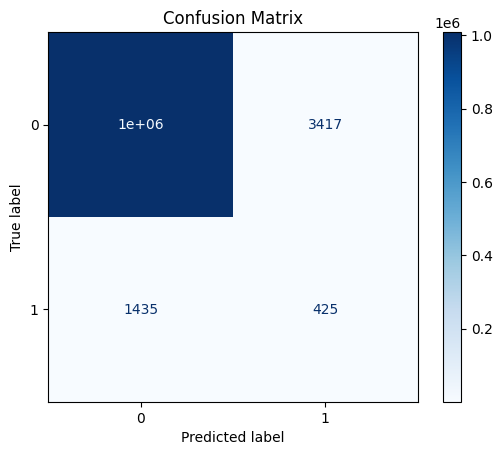

Average precision score: 0.10


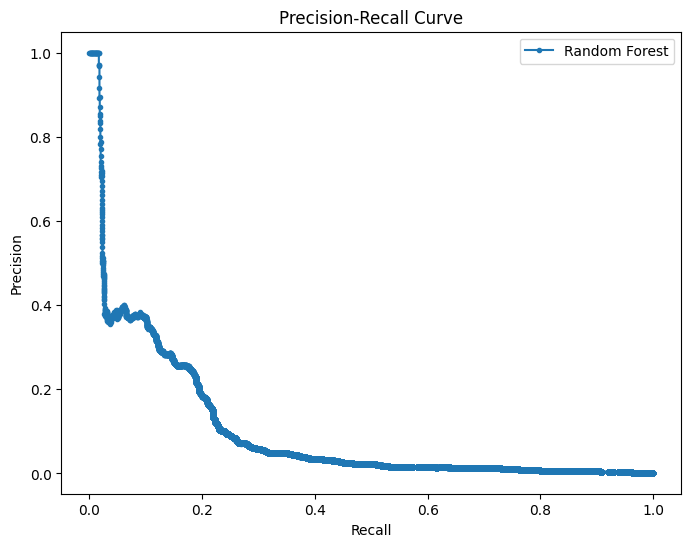

ROC AUC: 0.88


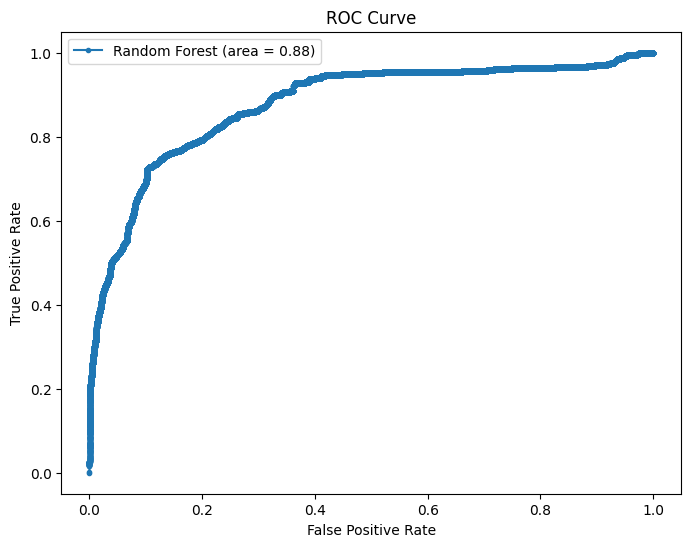

In [ ]:
# Plot and save the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')  # Save figure
plt.show()

y_scores = best_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)
print(f"Average precision score: {average_precision:.2f}")
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

#save it
plt.savefig("precision_recall_curve.png", dpi=300, bbox_inches='tight')  # Save figure
plt.legend()
plt.show()

#plot and save the roc auc curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.2f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label='Random Forest (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
#save it
plt.savefig("roc_curve.png", dpi=300, bbox_inches='tight')  # Save figure
plt.legend()
plt.show()

                                          Feature  Importance
114  line_status_description_Sent for fulfillment    0.116101
48                            time_in_status_mins    0.085798
145                             ship_node_CDC.078    0.048738
4                              promised_update_DS    0.042024
14                               availability_qty    0.025294
..                                            ...         ...
110                    sales_channel_SOCIAL_MEDIA    0.000000
56           time_to_WO_acknowledgement_date_days    0.000000
27                                ddc_ordered_qty    0.000000
123                             ship_node_CDC.020    0.000000
28                       ddc_ordered_qty_delivery    0.000000

[168 rows x 2 columns]


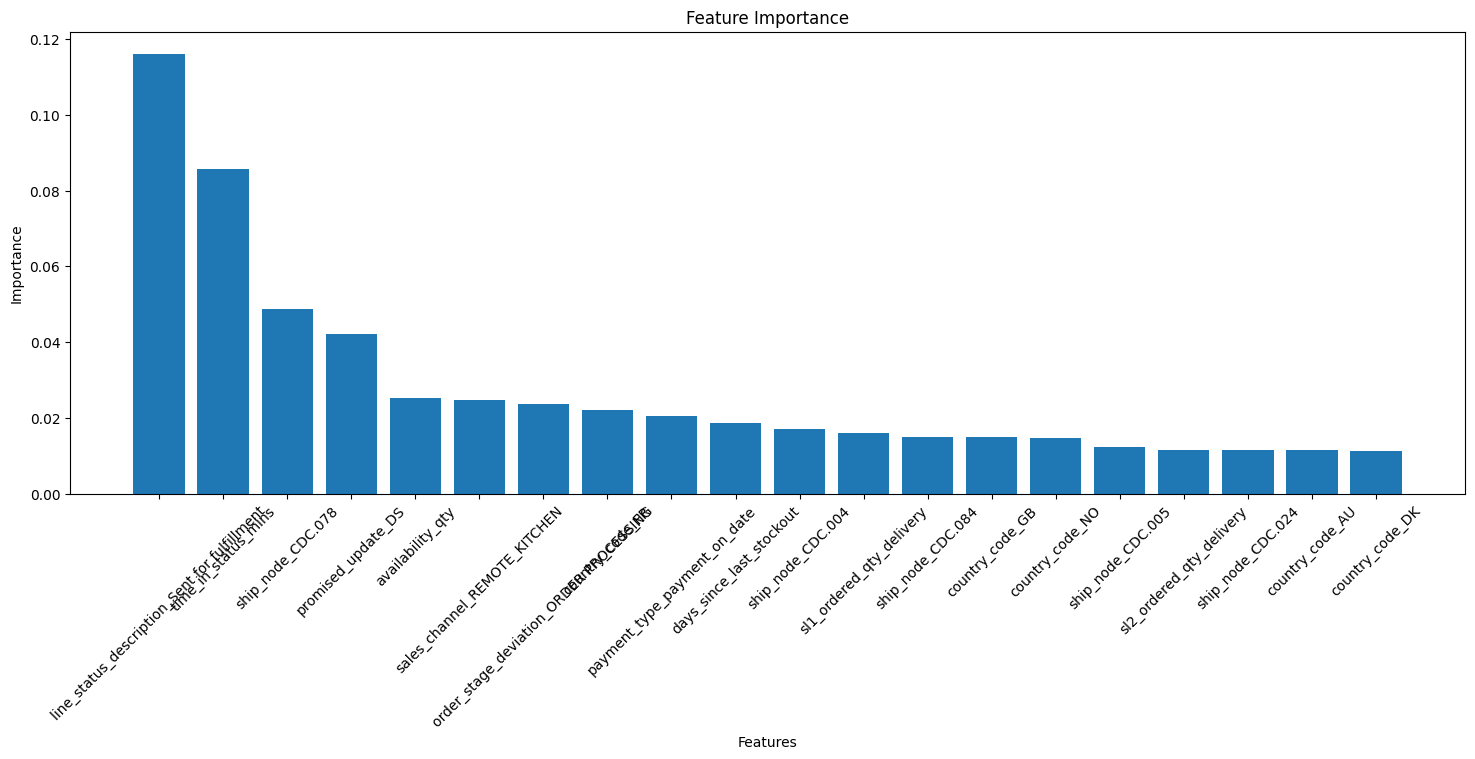

In [ ]:
# Get feature importance
importances = best_model.feature_importances_ if hasattr(best_model, 'feature_importances_') else best_model.get_feature_importance()

# Create a DataFrame for better visualization (optional)
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Replace with feature names if using a DataFrame
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize feature importance
print(feature_importance_df)

# Optional: Visualize the feature importances
plt.figure(figsize=(18, 6))
plt.bar(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.show()


#save the importances in csv
# feature_importance_df.to_csv("data/feature_importance.csv", index=False)

In [ ]:
from sklearn.metrics import precision_recall_curve

y_scores = best_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Example: maximize F1
f1 = 2 * precision * recall / (precision + recall + 1e-9)
best_idx = np.argmax(f1)
best_threshold = thresholds[best_idx]

print(f"Best threshold: {best_threshold:.4f} with F1: {f1[best_idx]:.4f}")

Best threshold: 0.7862 with F1: 0.2092


In [ ]:
y_pred = (y_scores >= best_threshold).astype(int)

tp_idx = (y_test == 1) & (y_pred == 1)
fn_idx = (y_test == 1) & (y_pred == 0)

X_tp = X_test[tp_idx]
X_fn = X_test[fn_idx]

In [ ]:
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)


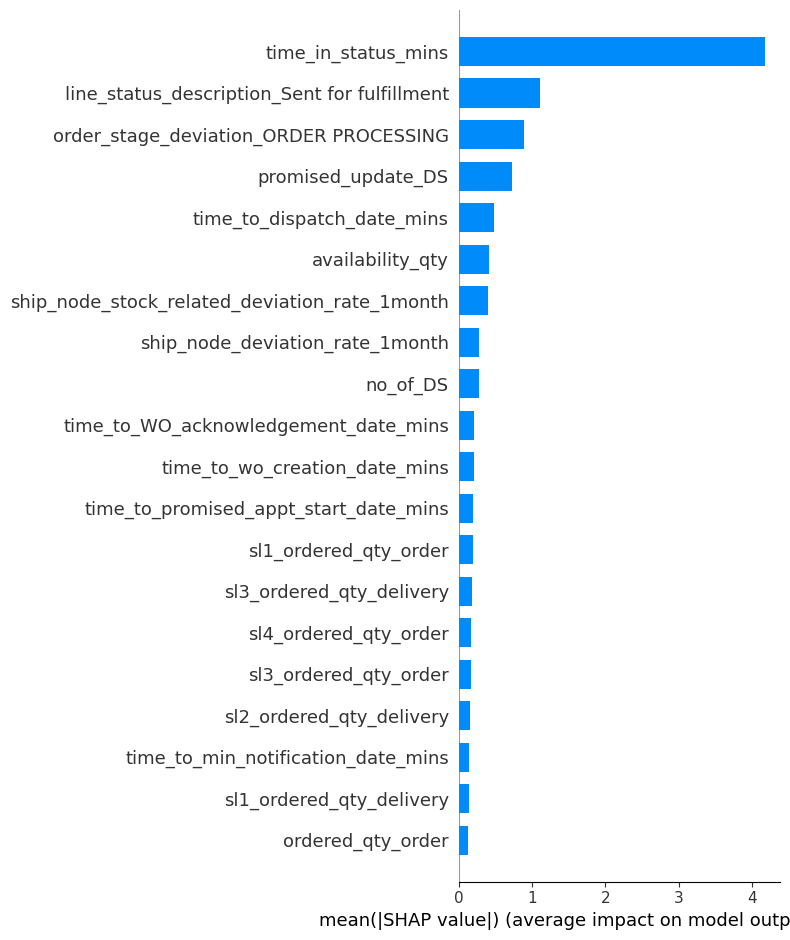

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

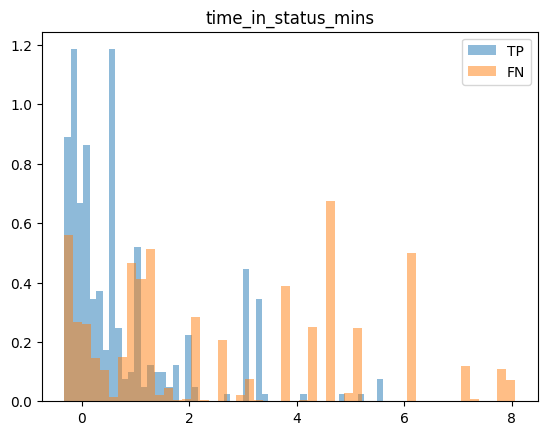

In [ ]:
import matplotlib.pyplot as plt

feature = "time_in_status_mins"

plt.hist(X_tp[feature], bins=50, alpha=0.5, label="TP", density=True)
plt.hist(X_fn[feature], bins=50, alpha=0.5, label="FN", density=True)
plt.legend()
plt.title(feature)
plt.show()

pca to reduce features ( use 1-2 features only )
using only created status
remove all categorical features
try catboost model




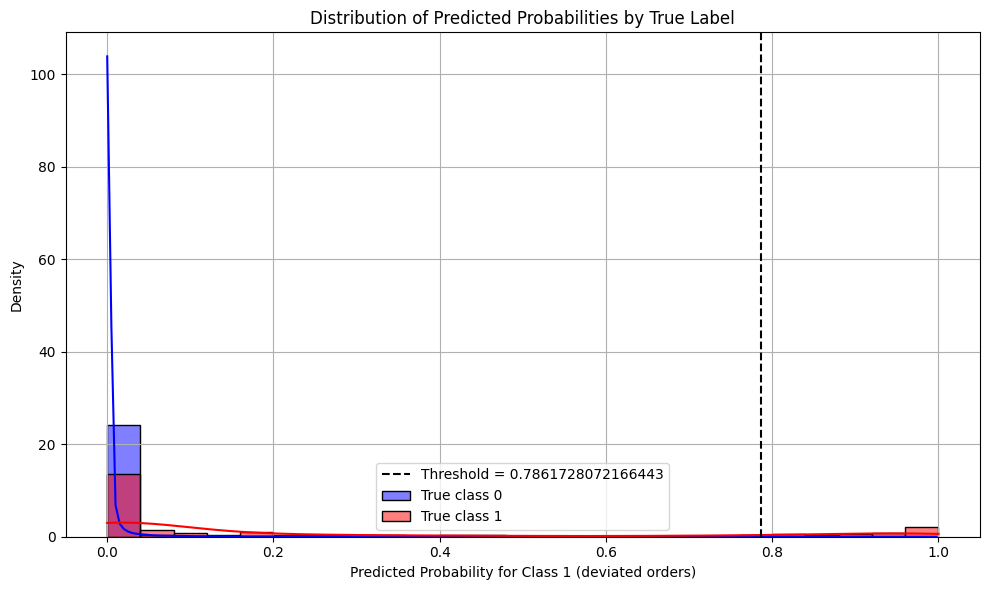

In [ ]:
probs = best_model.predict_proba(X_test)[:, 1]

# 5. Set threshold
threshold = best_threshold

# 6. Plot
plt.figure(figsize=(10, 6))
sns.histplot(probs[y_test == 0], color='blue', label='True class 0', kde=True, stat="density", bins=25)
sns.histplot(probs[y_test == 1], color='red', label='True class 1', kde=True, stat="density", bins=25)

# Draw threshold line
plt.axvline(threshold, color='black', linestyle='--', label=f'Threshold = {threshold}')

plt.xlabel('Predicted Probability for Class 1 (deviated orders)')
plt.ylabel('Density')
plt.title('Distribution of Predicted Probabilities by True Label')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## PCA

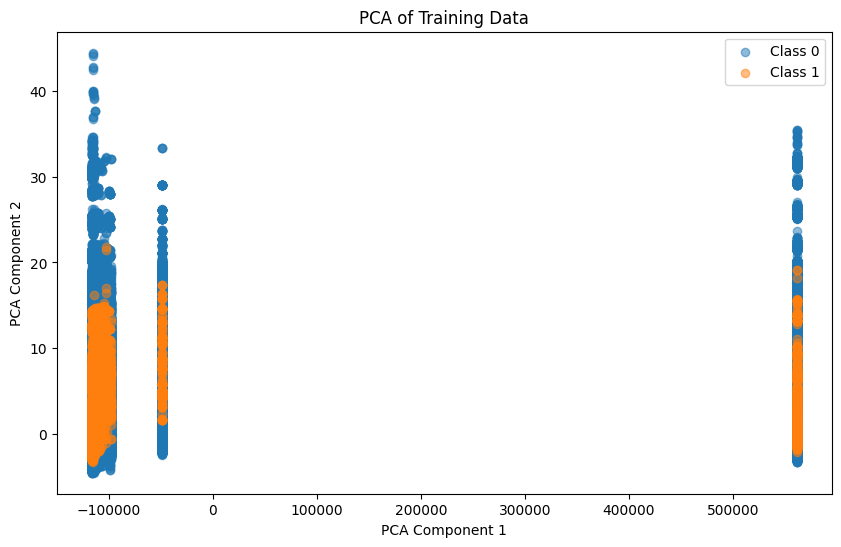

In [ ]:
#run pca on the dataset
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[y_train==0, 0], X_train_pca[y_train==0, 1], label='Class 0', alpha=0.5)
plt.scatter(X_train_pca[y_train==1, 0], X_train_pca[y_train==1, 1], label='Class 1', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Training Data')
plt.legend()
plt.show()

In [ ]:
#train xgboost model with pca features

best_model_pca = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    use_label_encoder=False,
    n_jobs=-1,
    verbosity=0,
    objective="binary:logistic",
    tree_method="hist",
)

best_model_pca.fit(X_train_pca, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [ ]:
#evaluate
y_pred_pca = best_model_pca.predict(X_test_pca)

print(accuracy_score(y_test, y_pred_pca))
print(f1_score(y_test, y_pred_pca))
print(classification_report(y_test, y_pred_pca))
print(confusion_matrix(y_test, y_pred_pca))

0.8624778647567466
0.016259244622593576
              precision    recall  f1-score   support

           0       1.00      0.86      0.93   1011795
           1       0.01      0.62      0.02      1860

    accuracy                           0.86   1013655
   macro avg       0.50      0.74      0.47   1013655
weighted avg       1.00      0.86      0.92   1013655

[[873103 138692]
 [   708   1152]]
